Попробуем выучить "ступеньку" на действительной прямой.

In [1]:
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../Github')

from batchflow import B, V, Pipeline, Config, Batch, Dataset
from batchflow.models.metrics import ClassificationMetrics
from batchflow.models.torch import TorchModel

from torch import Tensor

In [2]:
class MyBatch(Batch):
    components = 'features', 'labels'

Генерируем равномерно распределённую на [-1,1] случайную величину. <br>
Отрицательным значениям ставим в соответствие метку 10, остальным — 20.

In [3]:
def generate_data(size):
    x = np.random.uniform(low=-1, high=+1, size=size).astype('float32')
    y = np.where(x < 0, 10, 20).astype('float32')
    return x, y

Создаём и заполняем датасет.

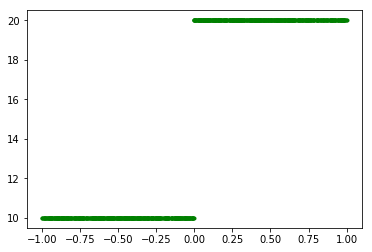

In [4]:
size = 1000
data = generate_data(size)
dataset = Dataset(index=size, batch_class=MyBatch, preloaded=data)
dataset.split()

plt.plot(data[0], data[1], 'g.');

Разность Relu(x+$\varepsilon$) и Relu(x) как раз должна давать искомую "ступеньку". <br>
Исходя из этого и определяем архитектуру сети.

In [5]:
config = {
    'inputs': dict(features={'shape': (1)},
                   labels={'shape': (1)}),
    'loss': 'MSE',
    'optimizer': 'Adam',
    'initial_block/inputs': 'features',
    'body/units': [2, 1],
    'body/activation' : 'Relu',
    'body/layout': 'fa f',
}

In [6]:
train_pipeline = (dataset.train.p
    .init_variable('losses', init_on_each_run=list)
    .init_model('dynamic', TorchModel, 'model', config)
    .train_model('model', B('features'), B('labels'), fetches='loss', save_to=V('losses'), mode='a'))

In [7]:
model = train_pipeline.get_model_by_name('model').model[0]
model

ConvBlock(
  (block): Sequential(
    (0): Dense(
      (linear): Linear(in_features=1, out_features=2, bias=True)
    )
    (1): Activation(
      (activation): ReLU(inplace)
    )
    (2): Dense(
      (linear): Linear(in_features=2, out_features=1, bias=True)
    )
  )
)

Веса по умолчанию:

In [8]:
model.state_dict()

OrderedDict([('block.0.linear.weight', tensor([[ 0.0259],
                      [-0.3994]])),
             ('block.0.linear.bias', tensor([-0.4833,  0.1413])),
             ('block.2.linear.weight', tensor([[-0.4025,  0.0804]])),
             ('block.2.linear.bias', tensor([-0.1185]))])

Запускаем.

100%|█████████▉| 3999/4000 [00:03<00:00, 1098.71it/s]


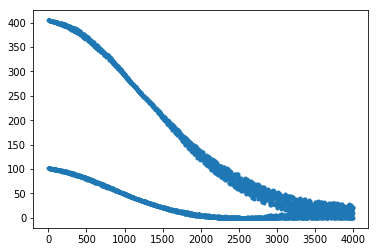

In [9]:
train_pipeline.run(batch_size=1, n_epochs=5, shuffle=True, bar=True)
plt.plot(train_pipeline.get_variable('losses'), '.');

Лосс сомнительный. Посмотрим, что выучилось.

In [10]:
def plot_model(model, left=-1, right=1):
    domain = Tensor([np.linspace(left, right)]).transpose(0,1)
    image = model.forward(domain)
    x = domain.detach().numpy()
    y = image.detach().numpy()
    plt.plot(x, y);

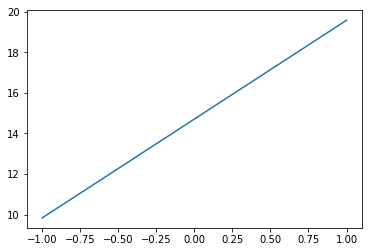

In [11]:
plot_model(model)

Meh. Зададим веса вручную.

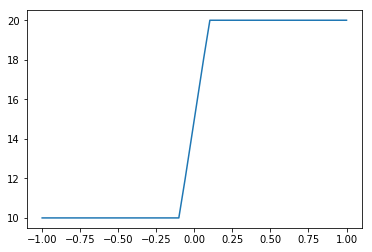

In [12]:
eps = 1e-1
new_params = [Tensor([[1.], [1.]]),
              Tensor([-eps, eps]),
              Tensor([-5./eps, 5./eps]),
              Tensor([10.])]

for i, param in enumerate(model.parameters()):
    param.data.copy_(new_params[i])
    
plot_model(model)

Что будет, если дать модели дообучиться? <br>
Сможет она уменьшить $\varepsilon$?

100%|█████████▉| 3999/4000 [00:03<00:00, 1097.73it/s]


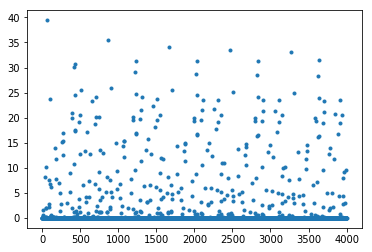

In [13]:
train_pipeline.run(batch_size=1, n_epochs=5, bar=True)
plt.plot(train_pipeline.get_variable('losses'), '.');

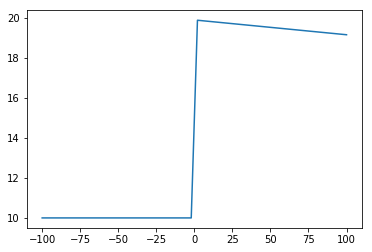

In [14]:
plot_model(model, -100, 100)

Не только не выучилась, но и испортила хорошую ступеньку :c